# Testing a trained GAN on galsim test objects

In [1]:
import sys
import os
import math
import time
import galsim
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

import torch.nn.functional as F
from photutils import create_matching_kernel

import astropy.io.fits as pyfits
import numpy as np
import matplotlib.pyplot as plt

from skimage.transform import downscale_local_mean
from scipy.ndimage import zoom


In [2]:
def galsim_clumpy_disk(maxclumps,plot_it = 'yes'):
    '''Returns a 64*64 image array of a disk galaxy similar to HST ACS'''
    random_seed = np.random.randint(1,10000)
    sky_level = 1.e6*np.abs(np.random.normal(1,0.02))     # ADU / arcsec^2
    pixel_scale = 0.06                                   # arcsec / pixel  (size units in input catalog are pixels)
    gal_flux = 1.e6*np.abs(np.random.normal(1,10))       # arbitrary choice, makes nice (not too) noisy images
    gal_g1 = np.random.normal(0.01,0.02)                
    gal_g2 = np.random.normal(0.01,0.02)                   


    bulge_frac       = np.abs(np.random.normal(0.1,0.05))
    disk_frac        = 1.0 - bulge_frac
    knot_frac        = np.abs(np.random.normal(0.3,0.05))
    smooth_disk_frac = disk_frac-knot_frac
    n_knots = np.abs(np.random.randint(1,maxclumps))
    hlr = np.abs(np.random.normal(0.3,0.1))
    hlr_knots = np.abs(hlr - np.abs(np.random.normal(0.08,0.02)))
    hlr_bulge = np.abs(np.random.normal(0.05,0.03))

    rng = galsim.BaseDeviate(random_seed+1)
    psf = galsim.Moffat(beta=3.5, fwhm=0.2, trunc=5.70)


    smooth_disk = galsim.Exponential(flux=smooth_disk_frac, half_light_radius=hlr)
    knots = galsim.RandomWalk(n_knots, half_light_radius=hlr_knots, flux=knot_frac, rng=rng)
    disk = galsim.Add([smooth_disk, knots])
    disk = disk.shear(e1=np.random.uniform(-0.5,0.5), e2=np.random.uniform(-0.5,0.5))
    bulge = galsim.DeVaucouleurs(flux=bulge_frac, half_light_radius=hlr_bulge)
    bulge = bulge.shear(e1=np.random.normal(0.0,0.1), e2=np.random.normal(0,0.1))
    gal = galsim.Add([disk, bulge])
    gal = gal.withFlux(gal_flux)
    gal = gal.shear(g1=gal_g1, g2=gal_g2)

    final = galsim.Convolve([psf, gal])

    # Draw the profile
    image = galsim.ImageF(64, 64)
    final.drawImage(image, scale=pixel_scale)
    image.addNoise(galsim.PoissonNoise(rng, sky_level * pixel_scale**2))
    arr = np.log10(image.array)
    arr[np.isnan(arr)]=0
    if plot_it == 'yes':
        plt.imshow(arr,origin='lower')
        plt.colorbar()
    return arr

torch.Size([1, 1, 64, 64])


/Users/shemmati/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in log10


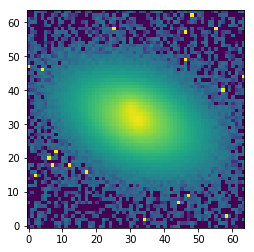

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

im = galsim_clumpy_disk(10,plot_it='no')
im = (255.0 / (im.max()+0.5) * (im)).astype(np.uint8)

plt.imshow(im,origin='lower')

#converting to pytorch tensor with the right size
gals = np.repeat(im[:,:, np.newaxis], 1, axis=2)
gals = np.repeat(gals[:,:,:,np.newaxis],1,axis = 3)
gals =torch.tensor(gals, device="cpu").float()
gals = gals.permute(2,3,0,1)
print(gals.shape)

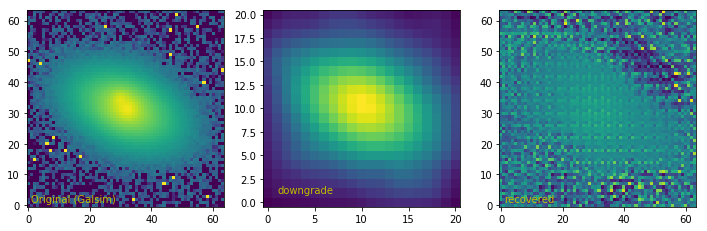

In [24]:
## making the CUDA Kernel transfering HST to Subaru HSC###


psf = pyfits.getdata('psf_i.fits')
psf = downscale_local_mean(psf,(3,3))
psf = psf[7:-8,7:-8]

psf_hsc = pyfits.getdata('psf-calexp-s16a_wide-HSC-I-15827-7,2-236.00000-42.00000.fits')
psf_hsc = psf_hsc[0:41,1:42]

kern = create_matching_kernel(psf,psf_hsc)
psfh = np.repeat(kern[:,:, np.newaxis], 1, axis=2)
psfh = np.repeat(psfh[:,:,:,np.newaxis],1,axis = 3)
kernel = torch.Tensor(psfh)
kernel = kernel.permute(2,3,0,1)
kernel =  kernel.float()


nc = 1
device = "cpu"
ngf = 64
ngpu = 3


class Shoobygen(nn.Module):

    def __init__(self,ngpu):
        super(Shoobygen, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            nn.ConvTranspose2d( 1, ngf * 8, 4, 1, 2, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 2, 2, 2, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
  
            nn.ConvTranspose2d(ngf*4, nc, 2, 2, 4, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
            output1 = output[:,:,:,:]

        else:
            output = self.main(input)
            output1 = output[:,:,:,:]

        return output1

netS = Shoobygen(ngpu).to(device)
netS.load_state_dict(torch.load('netG_epoch_460.pth',map_location='cpu'))

### read in an image with HST resoluion and downgrade (resample, PSF convolve, add noise) to HSC 
inputs = gals
real_cpu = inputs.to(device)
ajab = real_cpu.detach()


kernel = kernel.to(device)
im = real_cpu+0.25*torch.rand_like(real_cpu)
downsampled = F.upsample(im,scale_factor=1/3,mode='bilinear')
img = F.conv2d(downsampled, kernel,padding=int(((kernel.shape[3])-1)/2))
img = img[:,:,:,:]

### Use GAN to improve resolution
fake = netS(img)
fd = fake.detach()
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(ajab[0,0,:,:],origin='lower')
plt.text(1,1,'Original (Galsim)',color='y')
plt.subplot(1,3,2)
plt.imshow(img[0,0,:,:],origin='lower')
plt.text(1,1,'downgrade',color='y')
plt.subplot(1,3,3)
plt.imshow(fd[0,0,:,:],origin='lower')
plt.text(1,1,'recovered',color='y')

fake = netS(img)
vutils.save_image(fake.detach(),'fake_samples_test.png',normalize=True)